In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

import matplotlib.pyplot as plt

DATA_PATH="../../data/raw/"

### 전처리 및 엔지니어링 함수

In [37]:
# smoothed
def get_smoothed_map(train_df, col, target_col, m=10):
    overall_mean = train_df[target_col].mean()
    stats = train_df.groupby(col)[target_col].agg(['count', 'mean'])
    smooth_map = (stats['count'] * stats['mean'] + m * overall_mean) / (stats['count'] + m)
    return smooth_map, overall_mean

# preprocess
def preprocess_pipeline(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    
    # 수정: '2'를 1(학습 타겟)로, '1'을 0으로 매핑
    train['voted'] = train['voted'].replace({2: 1, 1: 0})
    
    def engineering(df):
        # Q_A 역채점 및 마키아벨리즘 점수
        qa_cols = [f'Q{i}A' for i in 'abcdefghijklmnopqrst']
        for col in qa_cols: # 간단한 역채점 예시 (실제 로직에 맞춰 수정 가능)
            df[col] = df[col] 
        df['mach_score'] = df[qa_cols].mean(axis=1)

        # Q_E 및 가족수 이상치 처리 (로그/클리핑)
        qe_cols = [f'Q{i}E' for i in 'abcdefghijklmnopqrst']
        for col in qe_cols:
            df[col] = np.log1p(df[col].clip(upper=df[col].quantile(0.99)))
        df['familysize'] = df['familysize'].clip(upper=df['familysize'].quantile(0.99))
            
        # tp/wr/wf 파생변수 생성
        # tp (빅 파이브)
        df['tp_Extraversion'] = (df['tp01'] + (7 - df['tp06'])) / 2
        df['tp_Agreeableness'] = ((7 - df['tp02']) + df['tp07']) / 2
        df['tp_Conscientiousness'] = (df['tp03'] + (7 - df['tp08'])) / 2
        df['tp_EmotionalStability'] = ((7 - df['tp04']) + df['tp09']) / 2
        df['tp_Openness'] = (df['tp05'] + (7 - df['tp10'])) / 2
        
        # wr, wf (지식 수준)
        df['wr_total'] = df[[f'wr_{i:02d}' for i in range(1, 14)]].sum(axis=1)
        df['wf_total'] = df[[f'wf_{i:02d}' for i in range(1, 4)]].sum(axis=1)
        
        # 성별 및 연령대
        df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
        df['age_encoded'] = df['age_group'].str.extract('(\d+)').astype(float).fillna(60).replace(0, 60)
        return df

    train = engineering(train)
    test = engineering(test)
    
    # Smoothed Target Encoding
    target_enc_cols = ['race', 'religion', 'urban', 'education', 'hand', 'married', 'engnat']
    for col in target_enc_cols:
        smooth_map, global_mean = get_smoothed_map(train, col, 'voted', m=10)
        train[f'{col}_enc'] = train[col].map(smooth_map)
        test[f'{col}_enc'] = test[col].map(smooth_map).fillna(global_mean)
        
    # 불필요 컬럼 제거
    drop_list = target_enc_cols + [f'tp{i:02d}' for i in range(1, 11)] + \
                [f'wr_{i:02d}' for i in range(1, 14)] + [f'wf_{i:02d}' for i in range(1, 4)] + \
                ['age_group', 'index']
    
    X = train.drop(columns=['voted'] + drop_list, errors='ignore')
    y = train['voted']
    X_test = test.drop(columns=drop_list, errors='ignore')
    
    return X, y, X_test


### 모델 아키텍처 (PyTorch)

In [38]:
class VotedClassifier(nn.Module):
    def __init__(self, input_dim):
        super(VotedClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

### 메인 실행

In [39]:
# 데이터 로드 및 분할
X, y, X_test_raw = preprocess_pipeline(DATA_PATH + 'train.csv', DATA_PATH + 'test_x.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n== data == \n{X.columns}")


== data == 
Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'familysize', 'gender', 'mach_score', 'tp_Extraversion',
       'tp_Agreeableness', 'tp_Conscientiousness', 'tp_EmotionalStability',
       'tp_Openness', 'wr_total', 'wf_total', 'age_encoded', 'race_enc',
       'religion_enc', 'urban_enc', 'education_enc', 'hand_enc', 'married_enc',
       'engnat_enc'],
      dtype='object')


In [40]:
# 스케일링
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test_raw)

# 텐서 변환
X_train_t = torch.FloatTensor(X_train_s)
y_train_t = torch.FloatTensor(y_train.values).view(-1, 1)
X_val_t = torch.FloatTensor(X_val_s)
y_val_t = torch.FloatTensor(y_val.values).view(-1, 1)
X_test_t = torch.FloatTensor(X_test_s)

# 학습 준비
model = VotedClassifier(X_train_t.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=1024, shuffle=True)

# 성능 기록용
history = {'train_loss': [], 'val_loss': [], 'val_auc': []}

print("Training Started...")

# 에포크 단위 tqdm 진행바
pbar = tqdm(range(25), desc="Overall Progress")

for epoch in pbar:
    model.train()
    t_loss = 0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    
    for bx, by in train_bar:
        optimizer.zero_grad()
        outputs = model(bx)
        loss = criterion(outputs, by)
        loss.backward()
        optimizer.step()
        
        t_loss += loss.item()

        train_bar.set_postfix(loss=loss.item())
    
    # 검증 단계
    model.eval()
    with torch.no_grad():
        v_probs = model(X_val_t)
        v_loss = criterion(v_probs, y_val_t).item()
        v_auc = roc_auc_score(y_val_t.numpy(), v_probs.numpy())
    
    avg_train_loss = t_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(v_loss)
    history['val_auc'].append(v_auc)
    
    # 핵심 지표 업데이트
    pbar.set_postfix(train_loss=f"{avg_train_loss:.4f}", val_auc=f"{v_auc:.4f}")

print("\n Training Complete")

print("\n" + "="*40)
print("Final Validation Performance Report")
print("="*40)

# 학습 과정 중 가장 높았던 AUC와 그때의 에포크
best_auc = max(history['val_auc'])
best_epoch = history['val_auc'].index(best_auc) + 1

# 가장 낮았던 Validation Loss
min_val_loss = min(history['val_loss'])

# 최종 에포크에서의 Accuracy 계산 (0.5 기준)
model.eval()
with torch.no_grad():
    final_val_probs = model(X_val_t).numpy()
    final_val_preds = (final_val_probs > 0.5).astype(int)
    final_acc = accuracy_score(y_val_t.numpy(), final_val_preds)

print(f"Best Validation AUC  : {best_auc:.4f} (at Epoch {best_epoch})")
print(f"Best Validation Loss : {min_val_loss:.4f}")
print(f"Final Validation ACC : {final_acc:.4f}")
print("="*40)

Training Started...


Overall Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/36 [00:00<?, ?it/s]


 Training Complete

Final Validation Performance Report
Best Validation AUC  : 0.7703 (at Epoch 9)
Best Validation Loss : 0.5560
Final Validation ACC : 0.6944


### 시각화 및 결과 저장

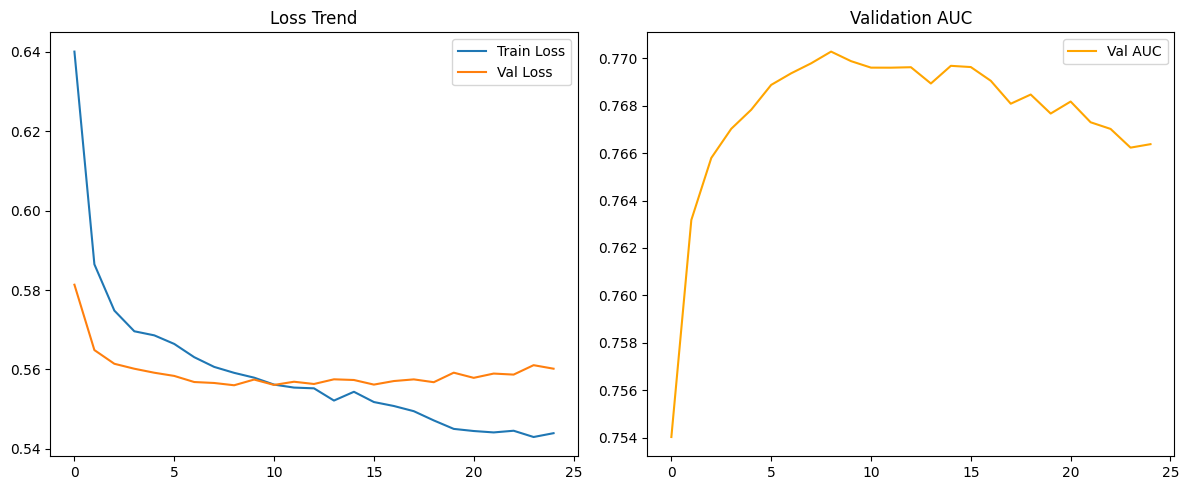

In [41]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Trend')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_auc'], label='Val AUC', color='orange')
plt.title('Validation AUC')
plt.legend()
plt.tight_layout()
plt.show()

### 평가 모드 결과 제출 양식 로드 및 저장

In [42]:
# 모델을 평가 모드로 전환
model.eval()
with torch.no_grad():
    test_probs = model(X_test_t).numpy().flatten()

# 제출 양식 로드 및 저장
sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
sub["voted"] = test_probs

sub.to_csv("submission_base.csv", index=False)
print("saved submission_base.csv")

saved submission_base.csv
